In [28]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from time import time
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

import os
from google.cloud import bigquery

In [29]:
#connecting notebook to gcloud bigquery to query data.
cred_file = r"C:\Users\V0V01S7\AppData\Roaming\gcloud\legacy_credentials\venkatasaiyashaswi.v@walmart.com\adc.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=cred_file
def query_bq(QUERY):
    client = bigquery.Client(project='wmt-edw-sandbox')
    query_job = client.query(QUERY) # API request
    rows = query_job.result() # Waits for query to finish
    df = rows.to_dataframe()
    return df

In [30]:
code = """select A.DRVR_USER_ID, 
B.ACTV_START_TS, B.ACTL_ACTV_END_TS, B.ACTV_DUR_MIN_QTY, B.ACTV_DT, 
from `wmt-edw-prod.WW_GEC_VM.DRVR` A inner join `wmt-edw-prod.WW_GEC_VM.DRVR_APPLN_ACTV` B on A.DRVR_USER_ID = B.DRVR_USER_ID
where A.MARKET_NM = 'Walmart Orlando' AND B.ACTV_NM = "ONLINE" and A.DRVR_USER_ID = "borges.asdrubal@gmail.com"
"""
df = query_bq(code)
df["ACTV_START_TS"] = pd.to_datetime(df["ACTV_START_TS"])
df["ACTL_ACTV_END_TS"] = pd.to_datetime(df["ACTL_ACTV_END_TS"])
df["ACTV_START_TS"] = df["ACTV_START_TS"] + pd.Timedelta(hours=3) #converting pacific time to eastern time (orlando market)
df["ACTL_ACTV_END_TS"] = df["ACTL_ACTV_END_TS"] + pd.Timedelta(hours=3)
df.head()

,DRVR_USER_ID,ACTV_START_TS,ACTL_ACTV_END_TS,ACTV_DUR_MIN_QTY,ACTV_DT
0,borges.asdrubal@gmail.com,2021-05-29 07:15:34.649,2021-05-29 07:15:43.682,0.150000000,2021-05-29
1,borges.asdrubal@gmail.com,2021-05-29 07:15:34.649,2021-05-29 07:15:43.682,0.150000000,2021-05-29
2,borges.asdrubal@gmail.com,2021-05-29 07:15:43.682,2021-05-29 10:30:00.000,194.270000000,2021-05-29
3,borges.asdrubal@gmail.com,2021-05-29 07:15:43.682,2021-05-29 10:30:00.000,194.270000000,2021-05-29
4,borges.asdrubal@gmail.com,2021-05-16 08:18:36.153,2021-05-16 09:57:34.087,98.950000000,2021-05-16


In [38]:
df['dayhour'] = df["ACTV_START_TS"].apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
time_line = pd.date_range(df["dayhour"].min(),df["dayhour"].max(),freq='H')
time_line = time_line.to_series()
ts = pd.DataFrame(time_line,columns = ["dayhour"])
ts = ts.set_index("dayhour")
ts = pd.merge(ts,df,how="left",on=["dayhour"])
ts["ACTV_DUR_MIN_QTY"] = ts["ACTV_DUR_MIN_QTY"].fillna(0)
ts = ts.drop(["DRVR_USER_ID","ACTV_DT"],axis=1)
ts = ts.set_index(["dayhour"],drop=True)
ts = ts.drop_duplicates()
ts = ts.dropna()
ts = ts.reset_index(drop=False)
ts['ACTV_START_TS'] = ts["ACTV_START_TS"].apply(lambda x: x.replace(second=0, microsecond=0))
ts['ACTL_ACTV_END_TS'] = ts["ACTL_ACTV_END_TS"].apply(lambda x: x.replace(second=0, microsecond=0))
def create_final_data(df):
    df['minutes'] = (df['ACTL_ACTV_END_TS'] - df['ACTV_START_TS']).dt.total_seconds()/60
    df = df[df['minutes']>0].reset_index(drop=True)
    # create an IntervalIndex which we can set as the axis (needed for re-indexing).
    # subtract one minute from end_time so that the minute of the termination is excluded.
    iv_idx = pd.IntervalIndex.from_arrays(df['ACTV_START_TS'],
                                          df['ACTL_ACTV_END_TS']-pd.Timedelta(minutes=1),
                                          closed='both')
    # create a new index with the extended frequency:
    new_idx = pd.date_range(df['ACTV_START_TS'].min(), df['ACTL_ACTV_END_TS'].max(), freq='min')
    # set the new index to get the extended frequency;
    # all minutes will have the value of the whole interval
    result = df['minutes'].set_axis(iv_idx).reindex(new_idx)
    # we can now calculate the duration per hour by resampling and summing the
    # boolean representation of the duration (1/0):
    result= result.fillna(0).astype(int).astype(bool).resample('H').sum()
    result.index.name = 'start_hour'
    return result
re = create_final_data(ts)
re = pd.DataFrame(re)
re

,minutes
start_hour,
2021-03-16 12:00:00,28
2021-03-16 13:00:00,11
2021-03-16 14:00:00,0
2021-03-16 15:00:00,0
2021-03-16 16:00:00,0
...,...
2022-07-12 13:00:00,60
2022-07-12 14:00:00,60
2022-07-12 15:00:00,60


In [39]:
re = re.asfreq('H')

In [40]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [41]:
X, y = create_features(re, label='minutes')

ft = pd.concat([X, y], axis=1)


In [42]:
re = re["2021-03-17 00:00:00":]
re.head()

,minutes
start_hour,
2021-03-17 00:00:00,0
2021-03-17 01:00:00,0
2021-03-17 02:00:00,0
2021-03-17 03:00:00,0
2021-03-17 04:00:00,0


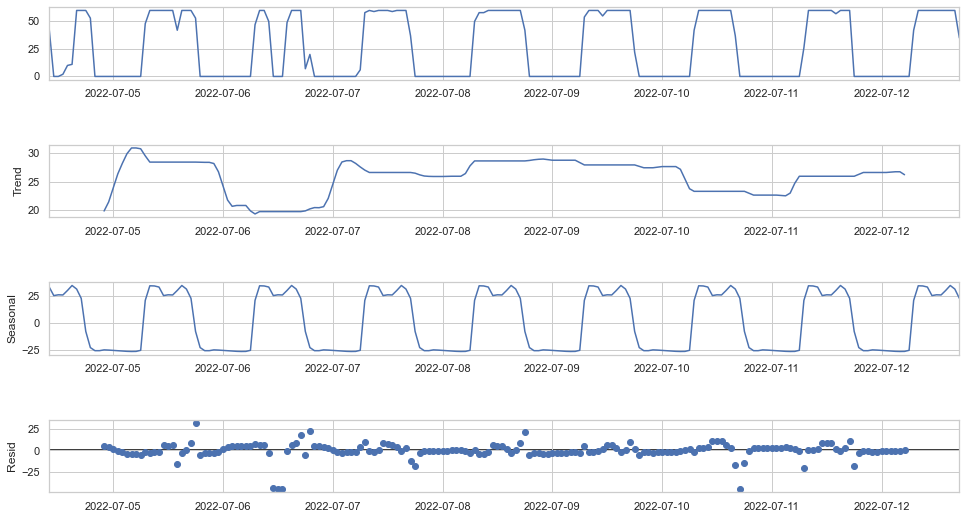

In [43]:
res = seasonal_decompose(re.tail(200))
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [44]:
split_date = '01-Jun-2022'
ts_train = re.loc[re.index <= split_date].copy()
ts_test = re.loc[re.index > split_date].copy()

In [45]:
res = adfuller(ts_train,regression='ct')
print('p-value:{}'.format(res[1]))

p-value:3.3687569372637956e-12


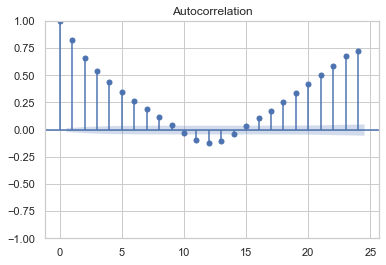

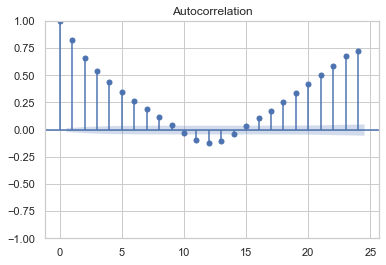

In [46]:
plot_acf(ts_train,lags=24)

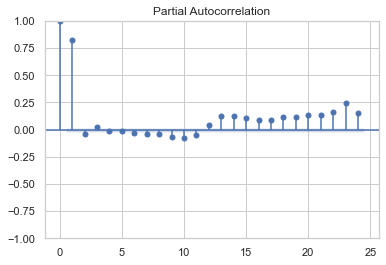

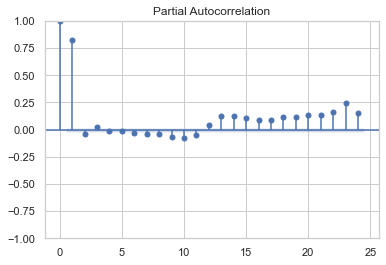

In [47]:
plot_pacf(ts_train,lags=24)

In [48]:
import statsmodels.api as sm

In [49]:
resDiff = sm.tsa.arma_order_select_ic(ts_train, max_ar=1, max_ma=1, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q) = (1, 1) is the best.


In [50]:
arima = sm.tsa.statespace.SARIMAX(ts_train,order=(1,1,1),freq='H',seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                minutes   No. Observations:                10585
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -40480.165
Date:                Tue, 12 Jul 2022   AIC                          80966.330
Time:                        18:43:25   BIC                          80988.131
Sample:                    03-17-2021   HQIC                         80973.689
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7634      0.006    132.455      0.000       0.752       0.775
ma.L1         -1.0034      0.001  -1562.211      0.000      -1.005      -1.002
sigma2       122.2013      0.955    128.005      0.000     120.330     124.072
===================================================================================
Ljung-Box (L1) (Q):                  37.48   Jarque-Bera (JB):             35857.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.94   Skew:                             1.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

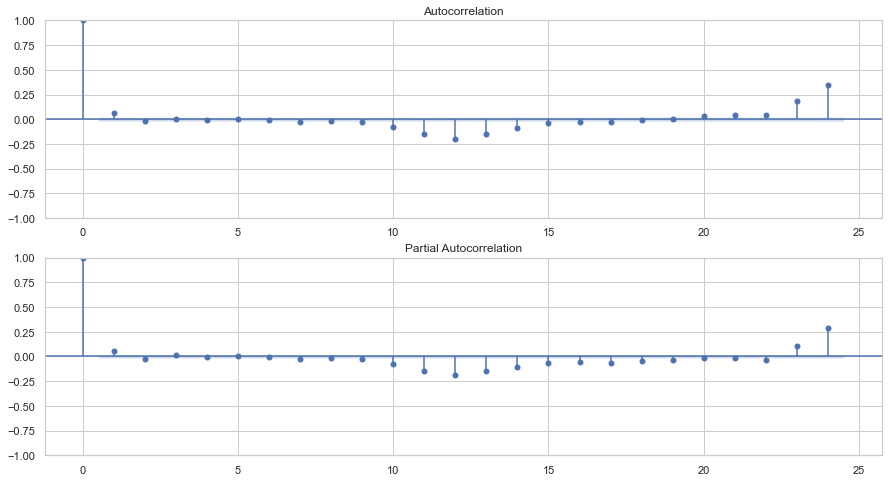

In [51]:
res = arima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=24, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=24, ax=ax[1])
plt.show()

In [52]:
tr_start,tr_end = ts_train.index[0],ts_train.index[-1]
te_start,te_end = ts_test.index[0],ts_test.index[-1]

In [53]:
from sklearn.metrics import mean_squared_error
pred = arima.predict(tr_end,te_end)[1:]
print('ARIMA model MSE:{}'.format(mean_squared_error(ts_test,pred)))

ARIMA model MSE:809.8535705760416


In [54]:
prediction = pd.DataFrame(pred)
prediction

,predicted_mean
2022-06-01 01:00:00,5.043770
2022-06-01 02:00:00,8.894349
2022-06-01 03:00:00,11.834007
2022-06-01 04:00:00,14.078239
2022-06-01 05:00:00,15.791559
...,...
2022-07-12 13:00:00,21.320664
2022-07-12 14:00:00,21.320664
2022-07-12 15:00:00,21.320664
2022-07-12 16:00:00,21.320664


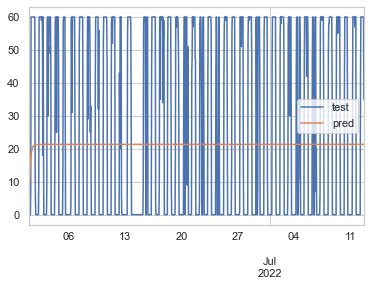

In [55]:
pd.DataFrame({'test':ts_test.minutes,'pred':prediction.predicted_mean}).plot();plt.show()

In [56]:
sarima = sm.tsa.statespace.SARIMAX(ts_train,order=(1,0,1),seasonal_order=(1,0,1,24),
                                enforce_stationarity=False, enforce_invertibility=False,freq='H').fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            minutes   No. Observations:                10585
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -38464.269
Date:                            Tue, 12 Jul 2022   AIC                          76938.539
Time:                                    18:43:59   BIC                          76974.862
Sample:                                03-17-2021   HQIC                         76950.801
                                     - 06-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5902      0.007     86.572      0.000       0.577       0.604
ma.L1          0.0099      0.008      1.196      0.232      -0.006       0.026
ar.S.L24       0.9973      0.001   1465.907      0.000       0.996       0.999
ma.S.L24      -0.8973      0.003   -349.068      0.000      -0.902      -0.892
sigma2        85.1144      0.526    161.967      0.000      84.084      86.144
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             37262.24
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               5.64   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
pred = sarima.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(ts_test,pred)))

SARIMA model MSE:260.4585990565046


In [58]:
pred = pd.DataFrame(pred)
pred

,predicted_mean
2022-06-01 01:00:00,-5.387629e-09
2022-06-01 02:00:00,-3.179782e-09
2022-06-01 03:00:00,-1.876709e-09
2022-06-01 04:00:00,-1.107634e-09
2022-06-01 05:00:00,1.746096e-05
...,...
2022-07-12 13:00:00,3.804194e+01
2022-07-12 14:00:00,3.756460e+01
2022-07-12 15:00:00,3.627274e+01
2022-07-12 16:00:00,3.709294e+01


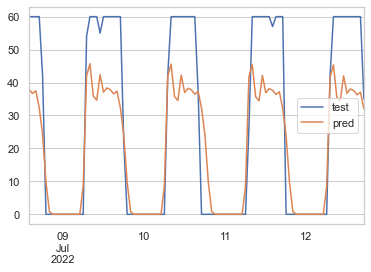

In [60]:
pd.DataFrame({'test':ts_test.tail(100).minutes,'pred':pred.tail(100).predicted_mean}).plot();plt.show()